In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
Image_Size=256
Batch_Size=32

In [22]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
"Dataset",
shuffle=True,
image_size=(Image_Size,Image_Size),
batch_size=Batch_Size)

Found 2152 files belonging to 3 classes.


In [52]:
class_names = dataset.class_names
n_classes=len(class_names)
n_classes,class_names

(3, ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy'])

In [24]:
len(dataset)

68

(32, 256, 256, 3)
tf.Tensor([2 1 1 1 0 1 2 0 1 1 1 1 1 0 1 0 1 2 1 1 0 0 0 0 0 1 1 1 0 0 0 2], shape=(32,), dtype=int32)
tf.Tensor(
[[[123. 115. 113.]
  [132. 124. 122.]
  [131. 123. 121.]
  ...
  [163. 157. 159.]
  [166. 160. 162.]
  [174. 168. 170.]]

 [[132. 124. 122.]
  [139. 131. 129.]
  [135. 127. 125.]
  ...
  [166. 160. 162.]
  [166. 160. 162.]
  [171. 165. 167.]]

 [[115. 107. 105.]
  [126. 118. 116.]
  [131. 123. 121.]
  ...
  [170. 164. 166.]
  [168. 162. 164.]
  [168. 162. 164.]]

 ...

 [[127. 121. 125.]
  [140. 134. 138.]
  [140. 134. 138.]
  ...
  [185. 183. 188.]
  [190. 188. 193.]
  [182. 180. 185.]]

 [[140. 134. 138.]
  [139. 133. 137.]
  [134. 128. 132.]
  ...
  [164. 162. 167.]
  [185. 183. 188.]
  [196. 194. 199.]]

 [[145. 139. 143.]
  [146. 140. 144.]
  [135. 129. 133.]
  ...
  [182. 180. 185.]
  [182. 180. 185.]
  [172. 170. 175.]]], shape=(256, 256, 3), dtype=float32)


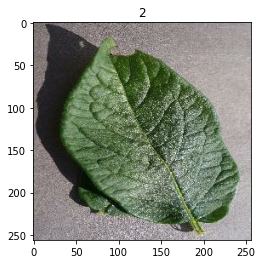

In [26]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch)
    print(image_batch[0])
    plt.title(label_batch.numpy()[0])
    plt.imshow(image_batch[0].numpy().astype("uint8"))

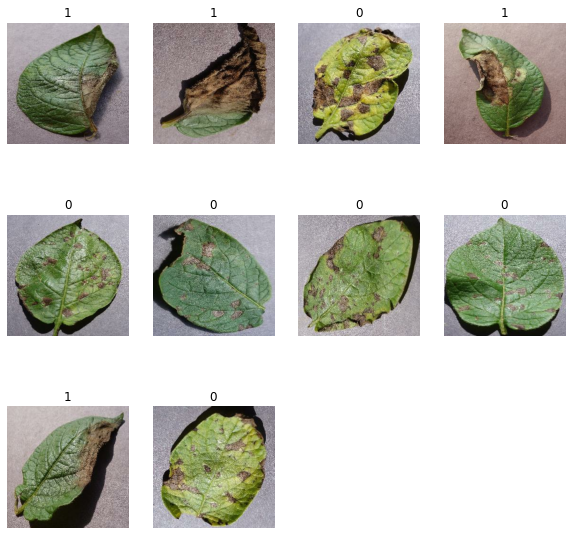

In [39]:
for image_batch, label_batch in dataset.take(1):
    plt.figure(figsize=(10,10))
    for i in range(10):
        plt.subplot(3,4,i+1)
        plt.title(label_batch.numpy()[i])
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.axis("off")

In [84]:
#test train split
train_size=int(0.8 * len(dataset))
test_size=int(0.1 * len(dataset))
val_size=int(0.1 * len(dataset))
train_size,test_size,val_size

(54, 6, 6)

In [90]:
train_ds=dataset.take(train_size)
test_ds=dataset.skip(train_size).take(test_size)
val_ds=dataset.skip(train_size + test_size).take(val_size)

In [101]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [102]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(Image_Size,Image_Size),
    layers.experimental.preprocessing.Rescaling(1/255.0)
])

In [103]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [104]:
model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu',input_shape=(Batch_Size,Image_Size,Image_Size,3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax')
])
model.build(input_shape=(Batch_Size,Image_Size,Image_Size,3))

In [108]:
model.compile(loss="sparse_categorical_crossentropy",
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

In [109]:
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_17 (Sequential)  (None, 256, 256, 3)       0         
                                                                 
 sequential_18 (Sequential)  (None, 256, 256, 3)       0         
                                                                 
 conv2d_40 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_41 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 62, 62, 64)       0         
 g2D)                                                

In [111]:
history=model.fit(train_ds,
                    epochs=50,
                    batch_size=Batch_Size,
                    validation_data=val_ds,
                    verbose=1)

Epoch 1/50
54/54 [==============================] - 78s 1s/step - loss: 0.0569 - accuracy: 0.9792 - val_loss: 0.3121 - val_accuracy: 0.9010
Epoch 2/50
54/54 [==============================] - 76s 1s/step - loss: 0.0565 - accuracy: 0.9792 - val_loss: 0.0618 - val_accuracy: 0.9844
Epoch 3/50
54/54 [==============================] - 79s 1s/step - loss: 0.0394 - accuracy: 0.9861 - val_loss: 0.1209 - val_accuracy: 0.9531
Epoch 4/50
54/54 [==============================] - 80s 1s/step - loss: 0.0302 - accuracy: 0.9907 - val_loss: 0.1114 - val_accuracy: 0.9583
Epoch 5/50
54/54 [==============================] - 85s 2s/step - loss: 0.0620 - accuracy: 0.9780 - val_loss: 0.0248 - val_accuracy: 0.9844
Epoch 6/50
54/54 [==============================] - 82s 2s/step - loss: 0.0333 - accuracy: 0.9878 - val_loss: 0.0586 - val_accuracy: 0.9688
Epoch 7/50
54/54 [==============================] - 77s 1s/step - loss: 0.0462 - accuracy: 0.9850 - val_loss: 0.0908 - val_accuracy: 0.9740
Epoch 8/50
54/54 [==

In [112]:
scores=model.evaluate(test_ds)

8/8 [==============================] - 6s 237ms/step - loss: 0.0447 - accuracy: 0.9844


In [113]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

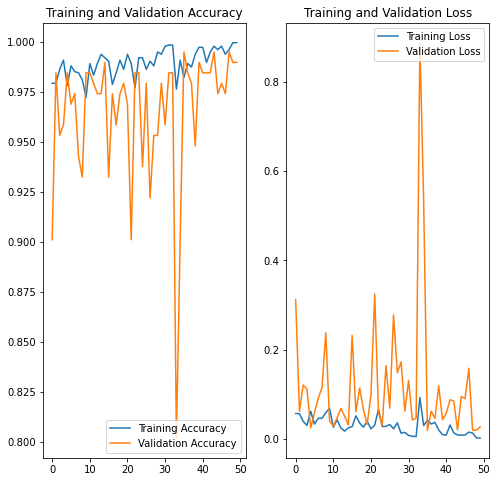

In [115]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(50), acc, label='Training Accuracy')
plt.plot(range(50), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(50), loss, label='Training Loss')
plt.plot(range(50), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Early_blight
1/1 [==============================] - 2s 2s/step
predicted label: Potato___Early_blight


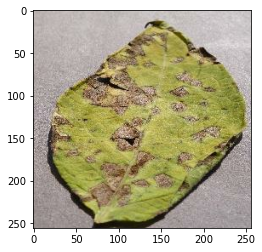

In [116]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [117]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 31ms/step


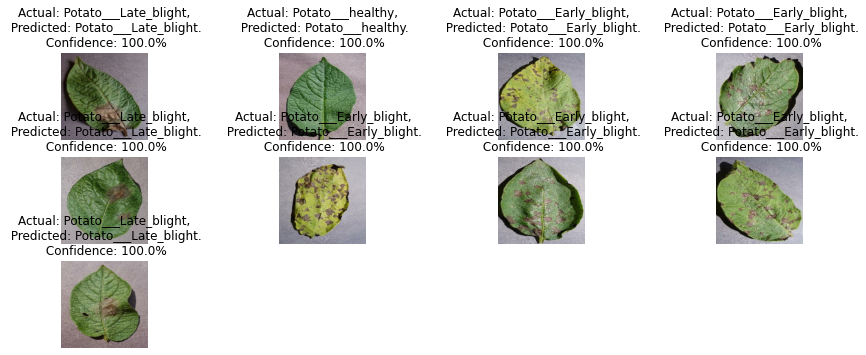

In [118]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(8, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [121]:
# import os
# model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
# model.save(f"../models/{model_version}")

In [122]:
model.save("potato.h5")